<a href="https://colab.research.google.com/github/EGEG1212/TIL_AudioSpeechProcessing/blob/main/1_%EC%98%A4%EB%94%94%EC%98%A4%EC%B2%98%EB%A6%ACAudio_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchaudio

     |████████████████████████████████| 1.9MB 5.5MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import librosa #librosa는 각종 음성 처리에 유용한 라이브러리
import librosa.display
import torch
import torchaudio #설치하는데 시간오래걸림;;
import IPython.display as ipd

## 오디오 데이터
- pytorch의 torchaudio를 사용해 내장 데이터셋을 가져옴

In [3]:
#pytorch의 torchaudio를 사용해 내장 데이터셋을 가져오는데 데이터6G가 크기때문에 시간이 55분소요됨
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

In [4]:
#불러온 데이터 확인
test_dataset[1]
#pytorch에 있는 텐서 구조를 따라서 오디오데이터가 있음

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)

In [5]:
#불러온 데이터의 형상확인
#데이터 길이만으로는 음성이 몇초에 해당하는디 duration을 알 수 없음
test_dataset[2][0].shape

torch.Size([1, 106000])

## 샘플링 
- 음성을 처리하기 위해, 아날로그정보를 잘개 쪼개>이산적인 디지털정보로 표현해야함    
- 무한히 쪼개어 저장할 수 없으므로, 기준을 세워 아날로그 정보를 쪼개 대표값이용. =샘플링이라한다    
- 주로 시간을 기준으로 아날로그정보를 쪼개는 Time Domain방식을 사용    

- Sampling rate 
  - 잘게 쪼갤수록 정보 손실이 줄어들지만, 데이터의 크기가 늘어남.    
- Sampling theorem  
  - smmpling rate가 최대 frequency보다 2배 커져야 함을 의미기가 늘어남.    
- Sampling theorem  
    - smmpling rate가 최대 frequency보다 2배 커져야 함을 의미
    - 일반적으로 smapling은 인간의 청각 영역에 맞게 형성
        - Audio CD: 44.1kHz(초당 44100 sample) 고품질  
        - Speech communication : 8kHz(초당 8000 sample ) 저품질.목소리 기준 유선전화 대화하는데 문제없는 정도  
  

In [6]:
audio_data = test_dataset[1][0][0]
sr = test_dataset[1][1]

print(audio_data, sr)
print('length:', len(audio_data))
print('duration:', len(audio_data) / sr)

ipd.Audio(audio_data, rate=sr)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) 16000
length: 52400
duration: 3.275


## 리샘플링 Resampling
- sample data의 dampling rate를 조정해 다시 sampling하는것  
- 이때 일반적 보간(interpolation)을할때는 low-pass filter를 사용  
- 메소드 `librosa.resample` 사용하면 편리하게 리샘플가능  
- 현 데이터는 `torch tensor`, `librosa`는 `numpy`배열을 받아들이기 때문에 변환이 필요  
- sampling rate를 절반으로 줄여, 길이도 절반으로 줄은 것을 확인할 수 있음  

In [7]:
audio_np = audio_data.numpy() #넘파이배열로 변환
y_8k = librosa.resample(audio_np, sr, 8000) #16000을 8000으로 줄임

print(len(audio_np), len(y_8k)) #길이가 반으로 줄었다 52400>26200  음질도 전화통화하는듯;
ipd.Audio(y_8k, rate=8000)

52400 26200


In [8]:
#한번 더 4000으로 줄여보자
audio_np = audio_data.numpy() 
y_4k = librosa.resample(audio_np, sr, 4000) 

print(len(audio_np), len(y_4k)) 
ipd.Audio(y_4k, rate=4000)  #초당 4000개의 샘플을 가지고 표현해야하기때문에, 음질이 안좋거나+발음이 안좋거나
#음질이 무전기급;

52400 13100


## Nomalization(정규화) & Quantization(양자화)
데이터간 음량이 제각각인 경우, nomalization을 하여 amplitude(진폭)를 [-1,1]범위로 조정  
여기서는 가장 간단한 방법인 데이터의 최대값으로 나눠주는 방법을 사용  

In [9]:
#정규화되었어도 원본파일과 음질이 같은듯 들린다 ㅋ
audio_np = audio_data.numpy()
normed_wav = audio_np / max(np.abs(audio_np))
ipd.Audio(normed_wav, rate=sr)

In [10]:
#Quantization:음질은 떨어지지만 용량이 줄어듦Quantization:음질은 떨어지지만 용량이 줄어듦; 지지직...노이즈추가됐네;;;...
bit = 8
max_value = 2 ** (bit-1) #2의 7승

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1) # -max_value부터 max_value-1까지
ipd.Audio(quantized_8_wav, rate=sr); #지지직...노이즈추가됐네;;;...
bit = 8
max_value = 2 ** (bit-1) #2의 7승

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1) # -max_value부터 max_value-1까지
ipd.Audio(quantized_8_wav, rate=sr)

## Mu-Law Encoding
- 사람의 귀는 작은소리의 차이는 잘잡아내는데 반해, 소리가 커질수록 그 차이를 잘 느끼지 못함    
- 이러한 특성을 wave값을 표현하는데 반영해 작은 값에는 높은 분별력을,    
큰 값끼리는 낮은 분별력을 갖도록 함    

사람 귀에 적합하도록 만들어준다?  

In [11]:
def mu_law(x, mu=255):
  return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

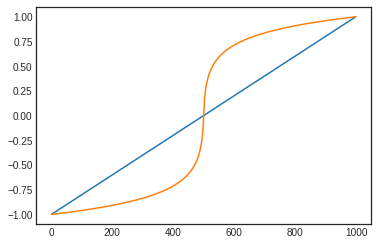

In [12]:
x = np.linspace(-1, 1, 1000) #-1부터 1까지 1000개의 샘플 x좌표
x_mu = mu_law(x)

plt.figure(figsize=[6, 4])
plt.plot(x)
plt.plot(x_mu)
plt.show()
#손실은 어느정도있는데.. 음량이 커졌음;;
#작은소리는 민감하게 높은소리는 

In [13]:
wav_mulaw = mu_law(normed_wav)
ipd.Audio(wav_mulaw, rate=sr)
#손실은 어느정도있는데.. 음량이 커졌음;;

# 오디오표현 Audio Representation
- sampling된 discrete한 데이터를 표현    
  - 시간의 흐름에 따라, 공기의 파동의 크기로 보는 Time-Domain Representation방법    
  -시간에 따라서 frequency의 변화를 보는 Time-Frequency Representation  

## 1.Waveform-Time-Domain Representation
Waveform은 오디오의 자연적인 표현  
시간이 x축으로 그리고 amplitude가 y축으로 표현  

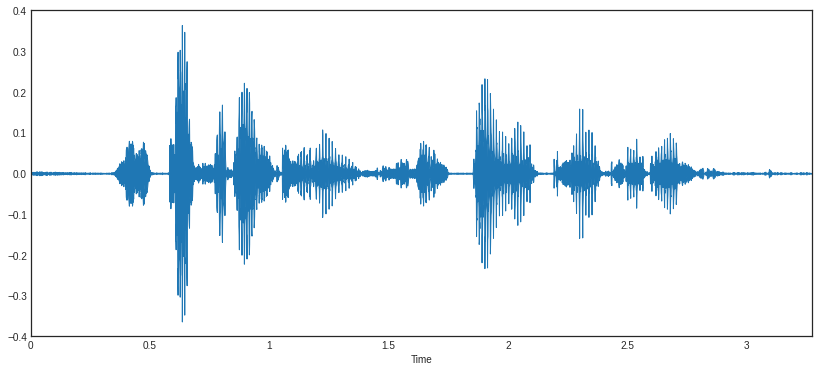

In [49]:
audio_np = audio_data.numpy()

fig = plt.figure(figsize=(14,6))
librosa.display.waveplot(audio_np[0:100000], sr=sr);
#시간에따른 웨이브(파동) 그래프

## 2.정현파(Sinusoid)-Time-Frequency Representation
- 모든 신호는 주파수(Frequency)와 크기(magnitude), 위상(phase)이 다른 정현파(sinuslida signal)의 조합으로 나타낼 수 있음  
- 퓨리에 변환은 조합된 정현파의 합(하모니) 신호에서 그 신호를 구성하는 정현파들을 각각 분리해내는 방법

In [50]:
# 사이노소이드 함수 사이노소이드 함수
def Sinusoid(A, f, phi, fs, t):
    t = np.arange(0, t, 1.0/fs) #0부터 t까지
    x = A * np.cos(2*np.pi*f*t+phi)
    return x

In [51]:
A = 0.9
f = 340 #라 음을 의미
phi = np.pi/2
fs = 22050
t = 1

In [52]:
sin = Sinusoid(A, f, phi, fs, t)

In [53]:
A = 0.9
f = 260 #여기만바꿔서
phi = np.pi/2
fs = 22050
t = 1

In [54]:
sin2 = Sinusoid(A, f, phi, fs, t)

In [55]:
# sin두개를 합치는
complexwave = sin + sin2

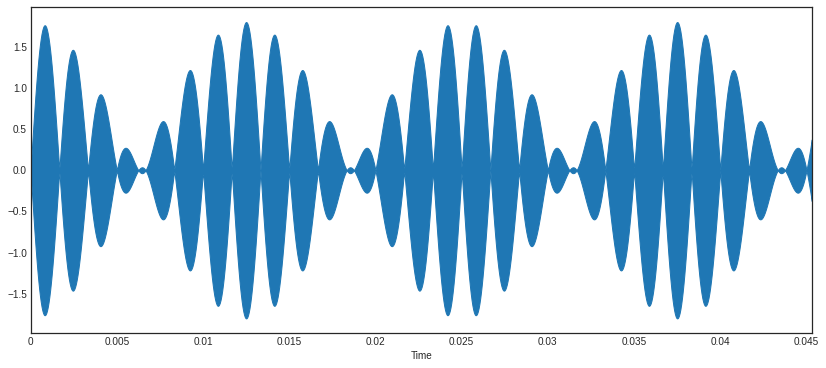

In [56]:
#figure로 나타내보자
fig = plt.figure(figsize=(14,6))
librosa.display.waveplot(complexwave[0:1000], sr=fs)
#사이노소이드 정현파로 신호를만들어낼수있다는의미!!!

In [57]:
#들어보자
ipd.Audio(sin + sin/2 + sin/4, rate=fs) #sin f = 340 #라음 삐-

In [58]:
ipd.Audio(sin2 + sin2/2 + sin2/4, rate=fs) #sin2 f = 260 #다른음 !!ㅋㅋㅋ

In [59]:
def generate_sinusoid_scale(pitches=[69], duration=0.5, fs=22050, amplitude_max=0.5):
    N = int(duration * fs)
    t = np.arange(N) / fs
    x = []
    for p in pitches:
      omega = 2 ** ((p - 69)/12 *440)
      x = np.append(x, np.sin(2 * np.pi * omega * t))
    x = amplitude_max * x / np.max(x)
    return x

In [60]:
duration = 1
fs = 22050
pitches = [36, 48, 60, 72, 84, 96]#피치를 다르게해서 출력 (96고음)
x = generate_sinusoid_scale(pitches=pitches, duration=duration, fs=fs)
print('Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}')
ipd.display(ipd.Audio(data=x, rate=fs))
#ipd.Audio(data=x, rate=fs)
#정보만 있으면 소리를 만들어낼 수 있다!

Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}


## 푸리에 변환(Fourier Transform)
- 푸리에 변환은 임의의 입력 신호를 다양한 주파수를 갖는 주기 함수들의 합으로 분해하여 표현하는 것을 의미  
푸리에 변환 식이 있다...(주기 함수들은 포함되어있지 않음)  
- 오일러 공식에 따라 다음과 같이 지수 함수와 주기 함수간 관계를 나타낼 수 있음  
- 결국 푸리에 변환은 입력 신호에 상관없이 sin,cos 같은 주기 함수들의 합으로 분해 가능함을 나타냄

### 이산 푸리에 변환(Discrete Fourier Transform, DFT)
- 우리가 샘플링한 데이터는 Discrete data라고 할 수 있음  
위의 푸리에 변환을 이산 영역으로 생각해볼 수 있음  
- 우리가 수집한 데이터 y에서 이산시계열 데이터가 주기N으로 반복한다고 할때,  
DFT는 주파수와 진폭이 다른 N개의 사인함수 합으로 표현 가능  
- 위 식을 보면 k의 range가 0부터 N-1로 변화했음을 알 수 있음    
- 이때 Spectrum Yk는 원래 시계열데이터에 대한 퓨리에 변환값  

DFT수식을 코드로 나타내면 다음과 같음:

In [61]:
def DFT(x):
    N = len(x)
    X = np.array([])
    nv = np.arange(N)

    for k in range(N):
         s = np.exp(1j * 2 * np.pi * k / N * nv)
         X = np.append(X, sum(x * np.conjugate(s)))
    return X

### Short-Time Fourier Transform(STFT)
- DFT는 시간의 흐름에 따라 신호의 주파수가 변했을때, 어느 시간대에 주파수가 변하는지 모름  
- STFT는 시간의 길이를 나눠서 이제 퓨리에 변환  
- 주파수 특성이 시간에 따라 달라지는 사운드를 분석하는 방법이며 우리가 사용하는 signal데이터에 적합 
- 시계열 데이터를 일정한 시간 구간(window size)로 나누고, 각 구간에 대해서 스펙트럼을 구함  
- STFT에 대한 식과 설명은 다음과 같음

In [62]:
print(audio_np.shape, sr)

(52400,) 16000


In [63]:
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024) 
print(S.shape, len(S[0]), S[0][0])

(513, 103) 103 (0.044214446+0j)


In [64]:
D = np.abs(S) ** 2
print(D.shape)

(513, 103)


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


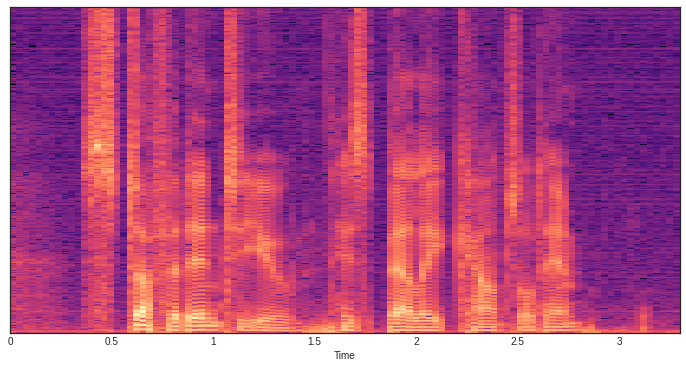

In [65]:
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(log_S, sr=16000, x_axis='time')

## 윈도우 함수(Window Function)
- Window function기능
  1. main-lobe를 제어
  2. side-lobe의 레벨 trade-off를 제어
  3. 깁스현상(불연속을 포함하는 파형이 푸리에 합성되었을 때 불연속 값에서 나타나는 불일치 현상) 방지



In [66]:
def frame_audio(audio, fft_size=1024, hop_size=20, sample_rate=22050):
  audio = np.pad(audio, int(fft_size/2), mode='reflect')
  frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
  frame_num = int((len(audio) - fft_size) / frame_len) + 1
  frames = np.zeros((frame_num, fft_size))

  for n in range(frame_num):
    frames[n] = audio[n*frame_len : n*frame_len+fft_size]

  return frames

audio_framed = frame_audio(audio_np)
print("Framed audio shape: {}".format(audio_framed.shape))

Framed audio shape: (119, 1024)


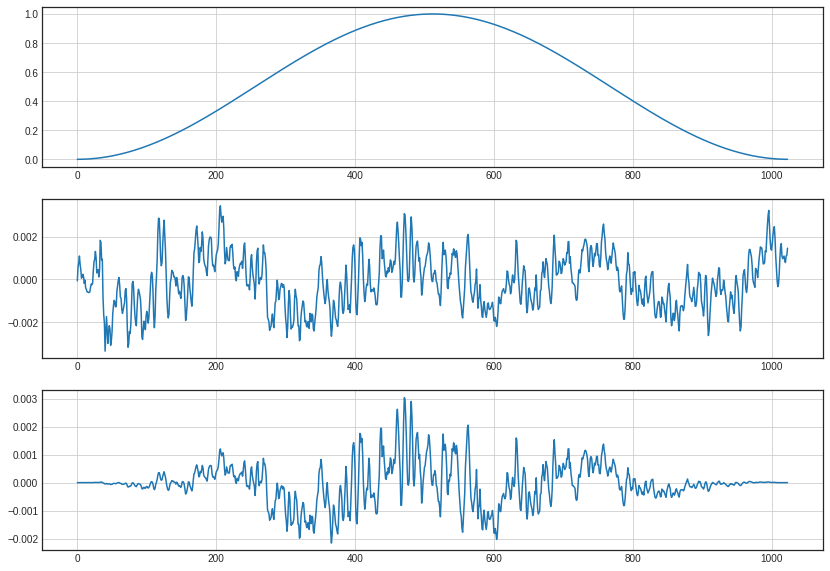

In [67]:
from scipy import signal

window = signal.get_window("hann", 1024, fftbins=True)
audio_win = audio_framed * window
idx = 5

plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.plot(window)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(audio_framed[idx])
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(audio_win[idx])
plt.grid(True)
plt.show()

## 윈도우크기(window Size)
 - window size는 time과 frequency의 resolution을 제어
    - short-window - 낮은 frequency resolution, 높은 time resolution
    - long-window - 높은 frequency resolution, 낮은 time resolution


## 스펙트로그램(Spectrogram)
 - 스펙트로그램은 소리나 파동을 시각화하여 파악하기 위한 도구
 - 파형과 스펙트럼의 특징이 조합되어 있음
 - 시간 축과 주파수 축의 변화에 따라 진폭의 차이를 인쇄 농도나 표시 색상 차이로 표현

## Linear Frequency Scale
 - 순음(single tone)들의 배음 구조를 파악하는데 적절
 - 분포가 저주파수 영역에 치우쳐져 있음 

## 멜 스케일(Mel Scale)
 - 주파수 단위를 다음 공식에 따라 멜 스케일로 변환
 $$m = 2595log10(1+f/700)$$
 - 일반적으로 mel-scaled bin을 FFT size보다 조금 더 작게 만듬
 - 해당 scale을 적용해 spectogram을 만든 것이 melspectogram

In [68]:
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
D = np.abs(S) ** 2

In [69]:
mel_basis = librosa.filters.mel(sr, n_fft=1024, n_mels=40)
mel_S = np.dot(mel_basis, D)
print(mel_S.shape)

(40, 103)


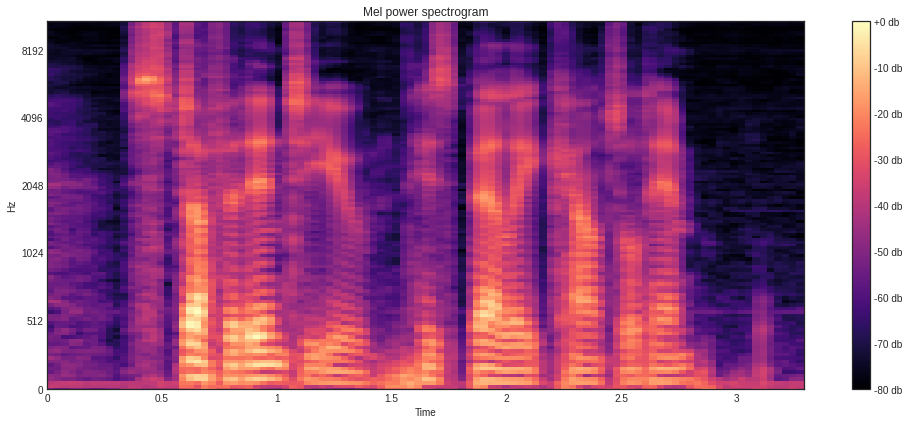

In [70]:
S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(14, 6))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f db')
plt.tight_layout()

## 바크 스케일(Bark Scale)
 - 귀가 인식하는 주파수의 영역은 대략 $20Hz ~ 2000Hz$로 가정, 하지만 주파수에 대한 사람의 인식은 비선형적
 - 귀와 뇌의 가청대역을 24개의 대역으로 나눈것을 Bark라고 함
 - Bark scale은 $500Hz$이하에서는 $100Hz$의 대역폭을, $500Hz$이상에서는 각 대역의 중심주파수의 대략 20%에 해당하는 대역폭을 가짐

 `20, 100, 200, 300, 400, 510, 630, 770, 920, 1080, 1270, 1480, 1720, 2000, 2320, 2700, 3150, 3700, 4400, 5300, 6400, 7700, 9500, 12000, 15500 (Hz)`

## Log Compression
 - 신호를 $10*log10(S/ref)$의 단위로 신호를 스케일링
 - spectrogram을 데시벨 유닛으로 전환

In [71]:
log_mel_S = librosa.power_to_db(mel_S)
print(log_mel_S.shape)

(40, 103)


## 이산 코사인 변환(Discrete Cosine Transform, DCT)
 - DCT은 n개의 데이터를 n개의 코사인 함수의 합으로 표현하여 **데이터의 양을 줄이는** 방식
 - 저주파수에 에너지가 집중되고 고주파수 영역에 에너지가 감소

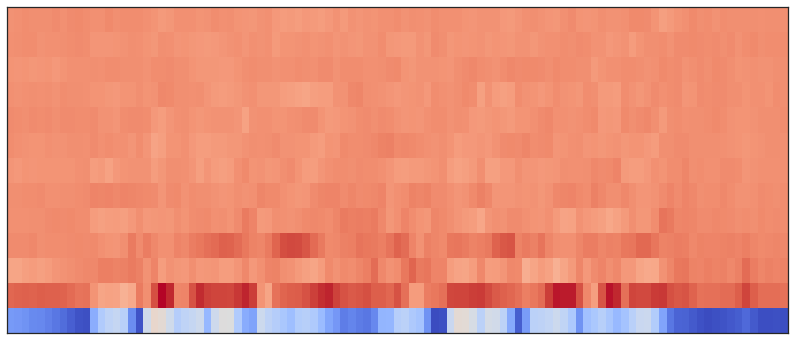

In [72]:
mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=13)
mfcc = mfcc.astype(np.float32)
plt.figure(figsize=(14,6))
librosa.display.specshow(mfcc);

(13, 103)


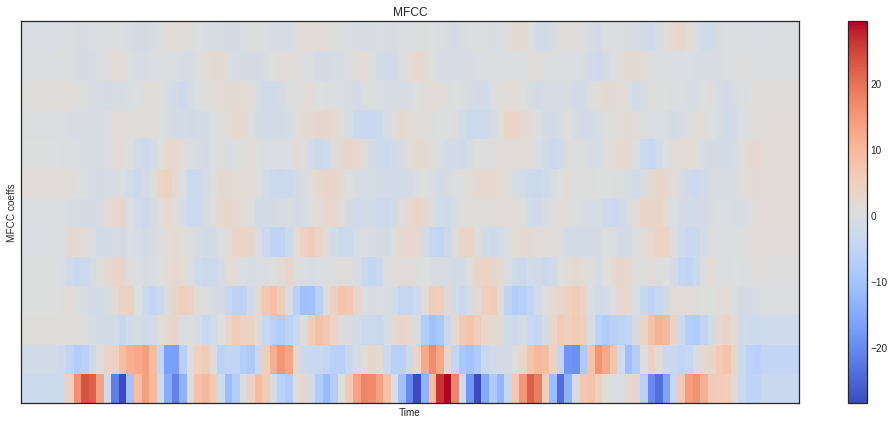

In [73]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
print(delta2_mfcc.shape)

plt.figure(figsize=(14, 6))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout() 
#저 주파수에 에너지가 몰려있다다

## 오디오 특징 추출(Audio Feature Extraction)
 - 모든 오디오 신호는 많은 특징으로 구성
 - 해결하려는 문제와 관련된 특성 추출 필요 (ex.오디오장르구별, 클러스트링)

### 스펙트럼 센트로이드(Spectral Centroid)
 - 주파수의 스펙트럼의 가중평균과 같음

In [74]:
spectral_centroids = librosa.feature.spectral_centroid(audio_np, sr=sr)[0]
print(spectral_centroids.shape)

(103,)


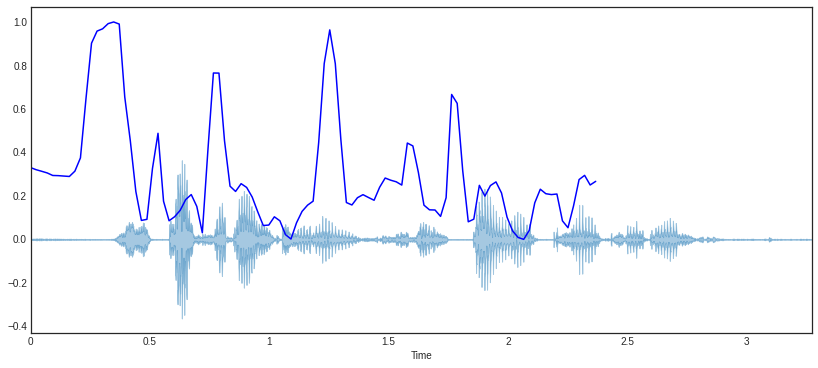

In [75]:
from sklearn.preprocessing import minmax_scale

plt.figure(figsize=(14, 6))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

librosa.display.waveplot(audio_np, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_centroids, axis=0), color='b')

### 스펙트럼 롤오프(Spectral Rolloff)
 - 신호의 모양을 측정
 - 고주파수가 0으로 감소하는 주파수를 나타냄

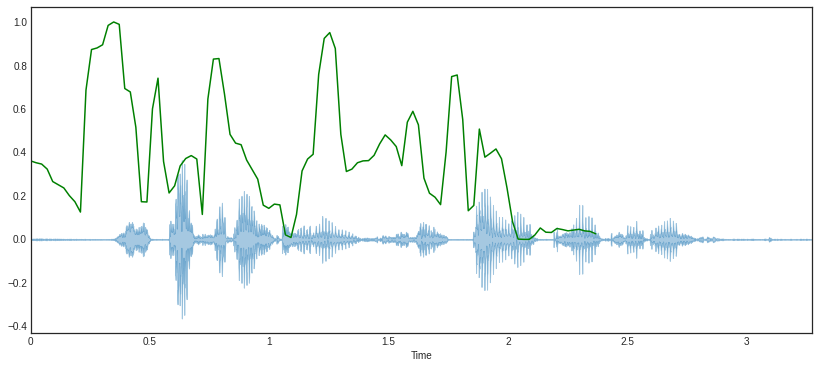

In [76]:
spectral_rolloff = librosa.feature.spectral_rolloff(audio_np+0.01, sr=sr)[0]
plt.figure(figsize=(14, 6))

librosa.display.waveplot(audio_np, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_rolloff, axis=0), color='g')

### 스펙트럼 대역폭
 - 스펙트럼 대역폭은 최대 파크의 절반(또는 최대 절반의 전체 너비 [FWHM])에서 빛의 대역 폭으로 정의되며 두 개의 수직 빨간색 선과 파장 축에서 SB로 표시

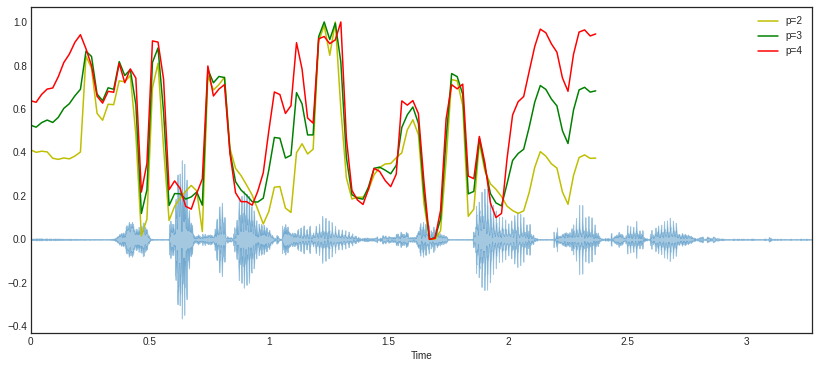

In [77]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(audio_np+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(audio_np+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(audio_np+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(14, 6))

librosa.display.waveplot(audio_np, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_bandwidth_2, axis=0), color='y')
plt.plot(t, minmax_scale(spectral_bandwidth_3, axis=0), color='g')
plt.plot(t, minmax_scale(spectral_bandwidth_4, axis=0), color='r')
plt.legend(('p=2', 'p=3', 'p=4'))

### 제로 크로싱 비율(Zero Crossing Rate)
 - 신호의 부드러움을 측정하는 매우 간단한 방법은 해당 신호의 세그먼트 내에서 제로 크로싱 수를 계산하는 것
 - 음성 신호는 느리게 진동(예를 들어, 100Hz 신호는 초당 제로 100을 교차하는 반면 무성 마찰음은 초당 3000개의 제로 교차를 가질 수 있음)

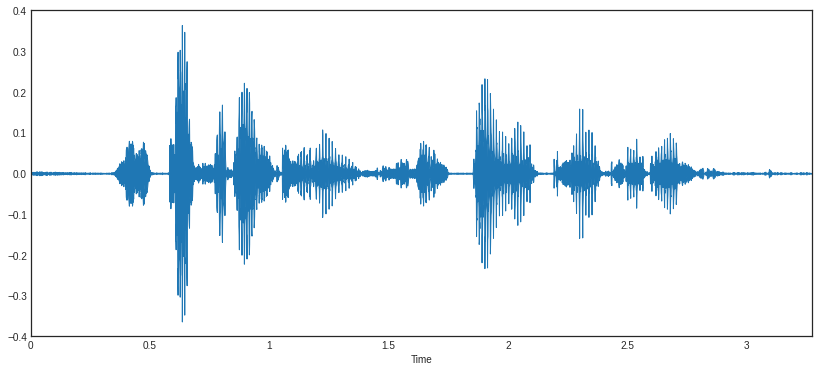

In [78]:
plt.figure(figsize=(14, 6))
librosa.display.waveplot(audio_np, sr=sr)

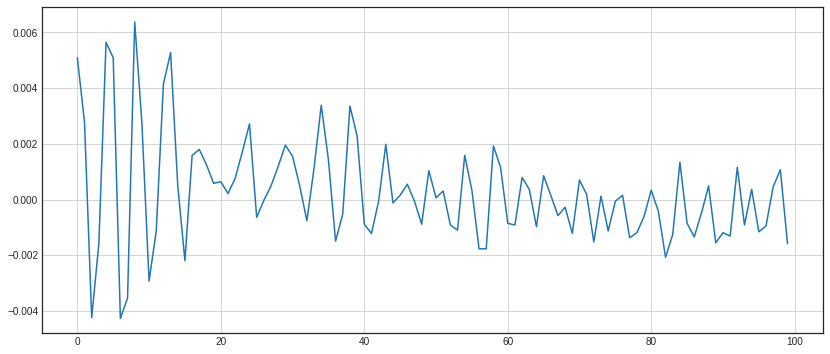

In [82]:
# zero영역이 잘 보이지 않아 확대해야함
n0 = 8000
n1 = 8100
plt.figure(figsize=(14, 6))
plt.plot(audio_np[n0:n1])
plt.grid()

In [84]:
zero_crossings = librosa.zero_crossings(audio_np[n0:n1], pad=False)
print(zero_crossing.shape)
print(sum(zero_crossings))

zcrs = librosa.feature.zero_crossing_rate(audio_np)
print(zcrs.shape)

(100,)
47
(1, 103)


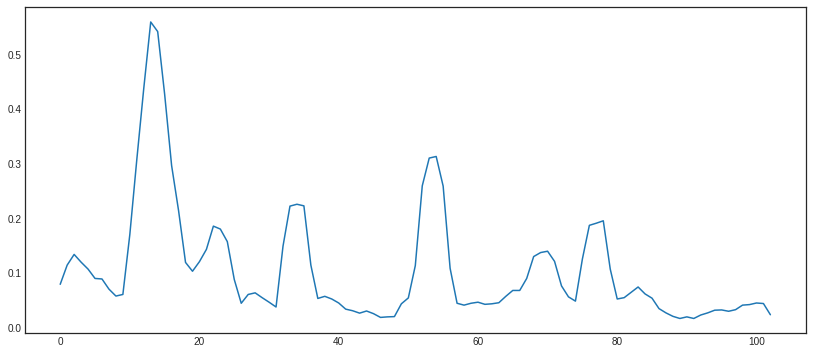

In [85]:
plt.figure(figsize=(14, 6))
plt.plot(zcrs[0])

## Mel-Frequency Cepstral Coefficients (MFCC)
 - 신호의 MFCC(Mel frequency cepstral coefficients)는 스펙트럼 포락선의 전체 모양을 간결하게 설명하는 작은 기능 집합(일반적으로 약 10-20)
 - 인간 목소리의 특성을 모델링 

(20, 103)


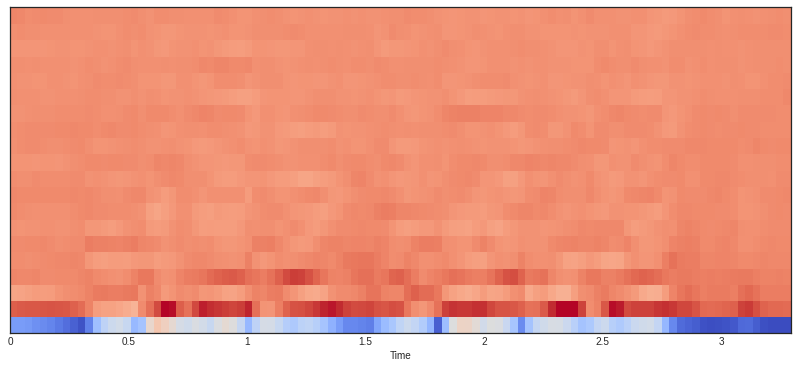

In [86]:
mfccs = librosa.feature.mfcc(audio_np, sr=sr)
print(mfccs.shape)

plt.figure(figsize=(14, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## 크로마크램(Chromagram)
 - 색도 특성 또는 벡터는 일반적으로 각각의 피치 클래스의 많은 에너지가, {C,C샵,D,D 번호는, }신호 내에 존재하는 방법을 나타내는 요소 특징 벡터
 - 음악 작품 간의 유사성 특정을 설명하는 강력한 방법 제공

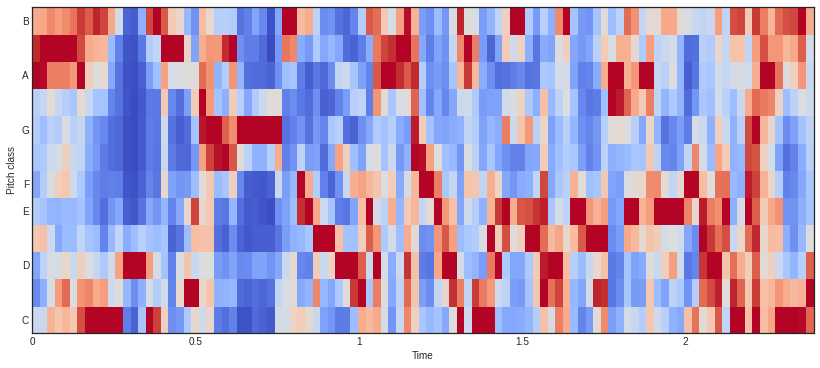

In [87]:
chromagram = librosa.feature.chroma_stft(audio_np, sr=sr, hop_length=512)
plt.figure(figsize=(14, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

## 오디오 필터(Audio Filter)

In [93]:
from scipy.signal import butter, lfilter, freqz

def butter_pass(cutoff, fs, btype, order=5):
  nyq = 0.5 * fs
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype=btype, analog=False)
  return b, a

def butter_filter(data, cutoff, fs, btype, order=5):
  b, a = butter_pass(cutoff, fs, btype, order=order)
  y = lfilter(b, a, data)
  return y

In [91]:
order = 6
fs = 16000
cutoff = 2048

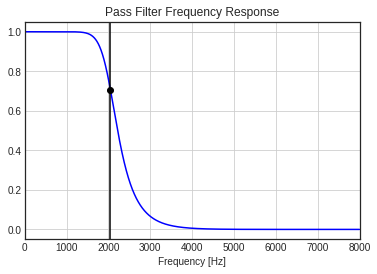

In [94]:
b, a = butter_pass(cutoff, fs, 'lowpass', order)

w, h = freqz(b, a, worN=8000)

plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Pass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [95]:
T = len(audio_np) / sr
n = int(T * sr)
t = np.linspace(0, T, n, endpoint=False)

y = butter_filter(audio_np, cutoff, fs, 'lowpass', order)
ipd.Audio(y, rate=fs)

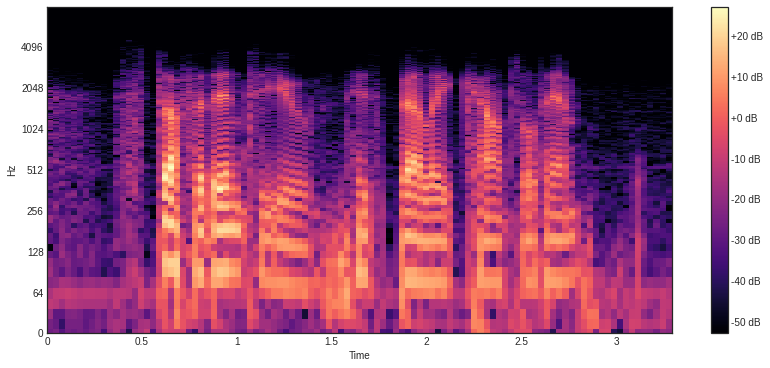

In [96]:
X = librosa.core.stft(y, n_fft=1024, hop_length=512,win_length=1024)
S = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(S, sr=fs, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')